<a href="https://colab.research.google.com/github/JOYCE1216/Data-Analysis-with-Open-Source/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_14%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 14강 비정형 데이터 분석 : 패션 사진 데이터 활용

### 목표

- 비정형 데이터를 인공지능 모델로 분석하여 실무에서 활용 가능한 보고서 형태로 가공

- 패션 트렌드라는 구체적인 주제를 통해, 비정형 데이터 분석의 실질적인 활용 방안을 경험하고자 함


### 분석 프로세스 개요

1. 데이터 수집
  - requests를 이용한 RSS 데이터 수집
  - lxml을 이용한 XML 파싱
  - 이미지 데이터 추출
2. VLM을 이용한 이미지 분석
  - 프롬프트를 이용한 이미지 필터링
  - 프롬프트를 이용한 스타일 분석
3. LLM을 이용한 키워드 분석 및 보고서 작성
  - 텍스트 전처리
  - 색상 및 스타일 키워드 추출
  - 워드 클라우드 분석
  - 보고서 작성

# 주의 : 런타임 GPU 로 설정 필요

In [1]:
# 4bit VLM 처리를 위한 bitsandbytes 설치
# LLM 처리를 위한 VLLM 설치 (오래걸리는 작업(>5분)이므로 미리 실행!)
!pip install bitsandbytes==0.45.3 vllm==0.7.3 transformers==4.48.2
# 필요 시 세션 재시작

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 

In [1]:
# 한글 처리를 위한 matplotlib 설정 (1)

!sudo apt-get install -y fonts-nanum
!sudo fc-cache –fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (9,062 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126435 files and dire

- 런타임 -> 세션 다시 시작

In [1]:
# 한글 처리를 위한 matplotlib 설정 (2)

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 1. 데이터 수집 및 전처리

## 14-1 RSS 피드에서 이미지 URL 추출

In [3]:
import requests
from lxml import etree
from lxml.html import fromstring
import pandas as pd

def extract_unique_images(rss_url):
    ## 주어진 RSS 피드 URL에서 고유한 이미지 URL들을 추출하는 함수 정의
    try:
        ## requests 라이브러리를 사용하여 RSS 피드 URL로부터 내용을 가져옴
        response = requests.get(rss_url)
        ## 가져온 XML 응답 내용을 lxml의 etree.fromstring으로 파싱하여 XML 트리 root를 생성
        root = etree.fromstring(response.content)
        image_urls = set()

        ## XML 트리에서 모든 'item' 태그를 XPath를 사용하여 순회
        for item in root.xpath('//item'):
            description = item.find('description')
            if description is not None and description.text:
                ## description의 텍스트 내용을 lxml.html.fromstring으로 파싱하여 HTML 트리를 생성
                html_tree = fromstring(description.text)
                ## HTML 트리에서 첫 번째 <img> 태그의 'src' 속성 값을 XPath를 사용하여 추출
                img_url = html_tree.xpath('string(//img/@src)')
                if img_url:
                    image_urls.add(img_url)

        return list(image_urls)

    except Exception as e:
        ## 오류 발생 시 오류 메시지를 출력하고 빈 리스트를 반환
        print(f"Error occurred: {e}")
        return []

rss_url = "https://glltn.com/feed/"
## extract_unique_images 함수를 호출하여 고유한 이미지 URL들을 추출
unique_images = extract_unique_images(rss_url)

## 추출된 이미지 URL 리스트를 사용하여 'image'라는 열을 가진 pandas DataFrame을 생성
df = pd.DataFrame(unique_images, columns=["image"])

In [4]:
df

,image
0,https://glltn.com/wp-content/blogs.dir/1/files...
1,https://glltn.com/wp-content/blogs.dir/1/files...
2,https://glltn.com/wp-content/blogs.dir/1/files...
3,https://glltn.com/wp-content/blogs.dir/1/files...
4,https://glltn.com/wp-content/blogs.dir/1/files...
5,https://glltn.com/wp-content/blogs.dir/1/files...
6,https://glltn.com/wp-content/blogs.dir/1/files...
7,https://glltn.com/wp-content/blogs.dir/1/files...
8,https://glltn.com/wp-content/blogs.dir/1/files...
9,https://glltn.com/wp-content/blogs.dir/1/files...


## 14-2 수집 데이터 확인

In [5]:
from IPython.display import display, HTML

def path_to_image_html(path):
    ## 이미지 경로를 HTML img 태그로 변환하는 함수
    return f'<img src="{path}" width="300" />'

## DataFrame의 스타일을 설정하여 이미지 너비를 300px로 지정
df.style.set_table_styles([{'selector': 'img', 'props': 'width: 300px;'}])

## DataFrame을 HTML로 변환하여 출력. 이미지 열은 path_to_image_html 함수로 포맷팅
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image
0,
1,
2,
3,
4,
5,
6,
7,
8,
9,


## 2. VLM을 이용한 이미지 분석

## 14-3 VLM 모델 로드

In [6]:
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer

## 'openbmb/MiniCPM-V-2_6-int4' 모델을 사전 훈련된 가중치와 함께 로드
## trust_remote_code=True는 허브에서 사용자 정의 코드를 실행할 수 있도록 허용
model = AutoModel.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True) #int 경량화된 모델
## 로드된 모델에 해당하는 토크나이저를 로드
tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
## 모델을 평가 모드로 설정 (드롭아웃 등 훈련 시에만 필요한 기능 비활성화)
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

configuration_minicpm.py: 0.00B [00:00, ?B/s]

modeling_navit_siglip.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- modeling_navit_siglip.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- configuration_minicpm.py
- modeling_navit_siglip.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_minicpmv.py: 0.00B [00:00, ?B/s]

resampler.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- resampler.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- modeling_minicpmv.py
- resampler.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.45G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenization_minicpmv_fast.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- tokenization_minicpmv_fast.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

MiniCPMV(
  (llm): Qwen2ForCausalLM(
    (model): Qwen2Model(
      (embed_tokens): Embedding(151666, 3584)
      (layers): ModuleList(
        (0-27): 28 x Qwen2DecoderLayer(
          (self_attn): Qwen2Attention(
            (q_proj): Linear4bit(in_features=3584, out_features=3584, bias=True)
            (k_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
            (v_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
            (o_proj): Linear4bit(in_features=3584, out_features=3584, bias=False)
          )
          (mlp): Qwen2MLP(
            (gate_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
            (up_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
            (down_proj): Linear4bit(in_features=18944, out_features=3584, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
          (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=

![](https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg)

## 14-4 이미지 질문 응답 예시

In [12]:
!ls

4434956914_6e95a22940_z.jpg  sample_data


In [7]:
from transformers import set_seed

## 재현성을 위해 시드(seed)를 42로 설정
set_seed(42)
## 예시 이미지 URL 정의
image_url = 'https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg'
## requests로 이미지 다운로드 후 PIL Image 객체로 열고 RGB 형식으로 변환
image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
## 이미지에 대한 질문 정의
question = 'how many cats in the photo?'
## 모델 입력 형식에 맞춰 메시지 구성 (이미지와 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지와 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x78f3e2c40f40>

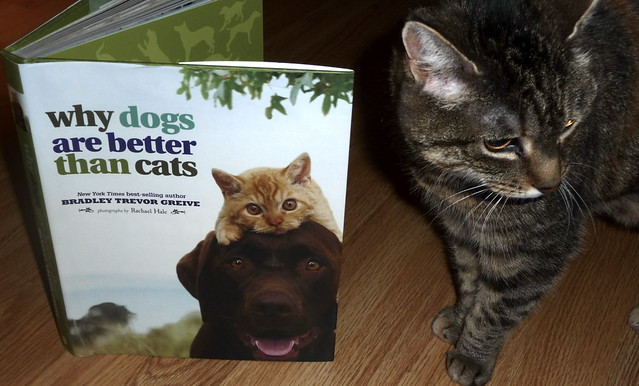

In [13]:
image_path = '4434956914_6e95a22940_z.jpg'

image = Image.open(image_path)
image

In [14]:
from transformers import set_seed

## 재현성을 위해 시드(seed)를 42로 설정
set_seed(42)
## 예시 이미지 URL 정의
#image_url = 'https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg'
## requests로 이미지 다운로드 후 PIL Image 객체로 열고 RGB 형식으로 변환
#image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
## 이미지에 대한 질문 정의
question = 'how many cats in the photo?'
## 모델 입력 형식에 맞춰 메시지 구성 (이미지와 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지와 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

preprocessor_config.json:   0%|          | 0.00/714 [00:00<?, ?B/s]

processing_minicpmv.py: 0.00B [00:00, ?B/s]

image_processing_minicpmv.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- image_processing_minicpmv.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- processing_minicpmv.py
- image_processing_minicpmv.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.12/dist-packages/transformers/models/auto/image_processing_auto.py:590: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=

1


In [11]:
image_url = 'http://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg'
response = requests.get(image_url)
response.status_code

429

In [17]:
set_seed(100)
## 이미지에 대한 질문을 업데이트. 책 표지의 고양이도 포함하도록 요청
question = 'how many cats in the photo? including the books cover.'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 업데이트된 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 업데이트된 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

2


In [16]:
set_seed(42)
## 이미지에 대한 질문을 'describe the photo'로 설정하여 이미지 내용을 설명하도록 요청
question = 'describe the photo'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 설명 요청 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지에 대한 설명을 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 (이미지 설명) 출력
print(result)

The photo shows a book with the title "why dogs are better than cats" and an image of a cat sitting on top of a dog's head. The book is placed on a flat surface, and next to it stands a real cat that appears to be looking at the book cover with some curiosity or disapproval.


## 14-5 의류 이미지 여부 판단

In [18]:
def is_picture_of_clothing(image_url):
    ## 이미지 URL이 의류 사진인지 판단하는 함수
    # 의류가 포함된 사진인지 확인하는 질문 작성 (영어로)
    question = 'Is this a picture of clothing? MUST say yes or no.'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer, temperature=0.1)
    print(result)
    ## 응답에 'yes'가 포함되어 있는지 확인하여 True/False 반환
    return 'yes' in result.lower()

## DataFrame의 'image' 열에 함수를 적용하여 'is_clothing' 열에 결과 저장
df['is_clothing'] = df['image'].apply(is_picture_of_clothing)

Yes, this image is of clothing. It appears to be a fashion photograph showcasing the individual's attire, which includes a black blazer and tie-dye trousers. The focus on the outfit suggests that it may be used for promotional or retail purposes, highlighting the style and design elements of the garments.
Yes, this image appears to be a fashion-oriented photograph showcasing clothing. The man is dressed in a stylish and coordinated outfit that includes an orange jacket with distinctive design elements such as ruched detailing and layered pockets, paired with white trousers. This type of presentation is commonly used in the fashion industry to highlight specific garments or collections.
Yes.
No, the image is not of clothing. It is a book cover with a photograph on it that depicts a street scene and includes text indicating the title and author's name. The content suggests that the book may be related to photography or urban life, but there are no visible garments or fashion items in the

## 14-6 의류 판단 결과 시각화

In [22]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing
0,,True
1,,True
2,,True
4,,True
5,,True
7,,True
8,,True
9,,True
10,,True
11,,True


## 14-7 의류 이미지 필터링

In [21]:
## 'is_clothing' 열의 값이 True인 행들만 필터링하여 DataFrame을 업데이트
df = df[df['is_clothing']]
dfb

,image,is_clothing
0,https://glltn.com/wp-content/blogs.dir/1/files...,True
1,https://glltn.com/wp-content/blogs.dir/1/files...,True
2,https://glltn.com/wp-content/blogs.dir/1/files...,True
4,https://glltn.com/wp-content/blogs.dir/1/files...,True
5,https://glltn.com/wp-content/blogs.dir/1/files...,True
7,https://glltn.com/wp-content/blogs.dir/1/files...,True
8,https://glltn.com/wp-content/blogs.dir/1/files...,True
9,https://glltn.com/wp-content/blogs.dir/1/files...,True
10,https://glltn.com/wp-content/blogs.dir/1/files...,True
11,https://glltn.com/wp-content/blogs.dir/1/files...,True


In [23]:
df

,image,is_clothing
0,https://glltn.com/wp-content/blogs.dir/1/files...,True
1,https://glltn.com/wp-content/blogs.dir/1/files...,True
2,https://glltn.com/wp-content/blogs.dir/1/files...,True
4,https://glltn.com/wp-content/blogs.dir/1/files...,True
5,https://glltn.com/wp-content/blogs.dir/1/files...,True
7,https://glltn.com/wp-content/blogs.dir/1/files...,True
8,https://glltn.com/wp-content/blogs.dir/1/files...,True
9,https://glltn.com/wp-content/blogs.dir/1/files...,True
10,https://glltn.com/wp-content/blogs.dir/1/files...,True
11,https://glltn.com/wp-content/blogs.dir/1/files...,True


## 14-8 의류 스타일 분석

In [24]:
def describe_style(image_url):
    ## 주어진 이미지 URL의 의류 스타일을 분석하는 함수
    question = 'Analyze the style of the clothes. Please let me explain the colors and change of trend.'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    ## 모델의 chat 함수를 호출하여 이미지에 대한 스타일 분석 응답 생성
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
    return result

## 필터링된 DataFrame의 'image' 열에 describe_style 함수를 적용
## 결과는 'style'이라는 새로운 열에 저장
df['style'] = df['image'].apply(describe_style)

In [25]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style
0,,True,"The style of the clothes can be characterized as a blend of classic and contemporary fashion trends. The black blazer with its high collar and structured design suggests a nod to traditional tailoring, often seen in formal or semi-formal wear. However, the presence of large buttons adds a modern twist, which is a common feature in contemporary menswear that favors bold details.\n\nThe tie-dye pants introduce an element of casualness and creativity, contrasting with the more conservative upper garment. Tie-dye has experienced several revivals over the decades, indicating it's a pattern that cycles through fashion trends, suggesting a blending of past and present styles. This combination of a classic blazer with a trendy, colorful pair of trousers could represent a personal expression of style, where individuality is valued alongside adherence to certain fashion norms.\n\nIn terms of color, the ensemble features a monochromatic top half contrasted by the vibrant blue tones of the bottom. This use of color can draw attention and add visual interest, breaking away from solid colors and highlighting the tie-dye pattern. It reflects a trend towards embracing both neutral and bold elements within one outfit, creating a balanced yet dynamic look."
1,,True,"The style of the clothes worn by the individual in the image suggests a contemporary urban fashion trend. The bright orange jacket with its ruffled details and functional design elements such as multiple pockets and drawstrings, indicates a blend of streetwear aesthetics with practical outdoor gear. This type of clothing is often associated with a youthful, adventurous spirit and is designed to be both stylish and utilitarian.\n\nThe color choice of orange is bold and eye-catching, which has been popular in various fashion cycles for its ability to stand out. It can also signify energy, creativity, and a break from the conventional. The white pants provide a stark contrast to the vibrant jacket, creating a visually striking look that is currently favored in modern casual fashion.\n\nOverall, the combination of the materials, colors, and design features points towards a fashion trend that values comfort, functionality, and a distinct visual impact. Such styles are often seen in urban environments where personal expression through clothing is highly valued."
2,,True,"The style of the clothes worn by the individual in the image suggests a preference for classic and timeless fashion. The gray tweed jacket is indicative of a traditional, possibly British-inspired aesthetic that has seen revivals over the years. Tweed, being a durable fabric often associated with outdoor wear, has been reinterpreted in various contexts from casual to formal settings.\n\nThe color choice of gray is versatile and can be considered neutral, which allows it to blend well with other colors and styles. Gray is often chosen for its understated elegance and ability to convey sophistication without being overly flashy. This particular shade seems to have a heather effect, adding texture and depth to the garment.\n\nAs for the trend, while tweed jackets have come and gone throughout fashion history, they tend to resurface periodically due to their enduring appeal. They are often seen as part of seasonal collections, especially during autumn and winter when such fabrics are more practical. The current trend might lean towards vintage or retro influences, where there's a resurgence of interest in garments that evoke nostalgia and a sense of timelessness.\n\nIn summary, the clothing style reflects a modern take on classic pieces, combining functionality with a nod to heritage fashion trends."
4,,True,"The clothing style depicted in the image leans towards a casual, possibly streetwear-inspired aesthetic. The knitted sweater is classic and versatile, often associated with comfort and warmth, which suggests it might be worn during cooler seasons or climates. The color palette of grey an

# 3. LLM을 이용한 키워드 분석 및 보고서 작성

## 14-9 언어 모델(LLM) 로드

In [29]:
from vllm import LLM, SamplingParams

## vLLM 라이브러리를 사용하여 'LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct' 모델을 로드
## gpu_memory_utilization은 GPU 메모리 사용 비율을 0.5로 설정
## max_model_len은 모델이 처리할 수 있는 최대 토큰 길이를 10000으로 설정
llm = LLM(model='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct',gpu_memory_utilization=0.5, max_model_len=10000)

config.json: 0.00B [00:00, ?B/s]

INFO 09-25 08:51:48 config.py:2444] Downcasting torch.float32 to torch.float16.
INFO 09-25 08:52:12 config.py:549] This model supports multiple tasks: {'classify', 'reward', 'embed', 'generate', 'score'}. Defaulting to 'generate'.
INFO 09-25 08:52:12 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', speculative_config=None, tokenizer='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=10000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/563 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

INFO 09-25 08:52:15 cuda.py:178] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 09-25 08:52:15 cuda.py:226] Using XFormers backend.
INFO 09-25 08:52:16 model_runner.py:1110] Starting to load model LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct...
INFO 09-25 08:52:16 weight_utils.py:254] Using model weights format ['*.safetensors']


model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.65G [00:00<?, ?B/s]

INFO 09-25 09:03:33 weight_utils.py:270] Time spent downloading weights for LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct: 677.006959 seconds


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 09-25 09:04:15 model_runner.py:1115] Loading model weights took 4.5146 GB
INFO 09-25 09:04:18 worker.py:267] Memory profiling takes 2.70 seconds
INFO 09-25 09:04:18 worker.py:267] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.50) = 7.37GiB
INFO 09-25 09:04:18 worker.py:267] model weights take 4.51GiB; non_torch_memory takes 0.02GiB; PyTorch activation peak memory takes 0.98GiB; the rest of the memory reserved for KV Cache is 1.86GiB.
INFO 09-25 09:04:18 executor_base.py:111] # cuda blocks: 1625, # CPU blocks: 3495
INFO 09-25 09:04:18 executor_base.py:116] Maximum concurrency for 10000 tokens per request: 2.60x
INFO 09-25 09:04:25 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utili

Capturing CUDA graph shapes: 100%|██████████| 35/35 [01:25<00:00,  2.45s/it]

INFO 09-25 09:05:50 model_runner.py:1562] Graph capturing finished in 86 secs, took 0.21 GiB
INFO 09-25 09:05:50 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 95.80 seconds


## 14-10 색상 정보 추출

In [ ]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_color(style):
  ## 주어진 스타일 설명 텍스트에서 색상을 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 색상을 한글로 추출해주세요. 색상 외에 다른 정보는 " # vlm이 작성한 글에서 색상 정보 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_color 함수를 적용
## 결과는 'color'라는 새로운 열에 저장
df['color'] = df['style'].apply(extract_color)

## 14-11 스타일 키워드 추출

In [ ]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_color(style):
  ## 주어진 스타일 설명 텍스트에서 스타일 키워드를 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"" # vlm이 작성한 글에서 스타일 키워드 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_color 함수를 적용 (함수 이름은 이전과 동일하지만 기능 변경)
## 결과는 'keyword'라는 새로운 열에 저장
df['keyword'] = df['style'].apply(extract_color)

In [ ]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

## 14-12 텍스트 데이터 정제

In [ ]:
import re

def clean_text(text):
    ## 텍스트에서 특수 문자 및 HTML 태그를 제거하고 소문자로 변환하는 함수
    if isinstance(text, str):
       ## 영문, 숫자, 한글, 공백을 제외한 모든 문자 제거
       text = re.sub(r'[^a-zA-Z0-9가-힣\s]', '', text)
       ## HTML 태그 제거
       text = re.sub(r'<[^>]*>', '', text)
       ## 텍스트를 소문자로 변환
       text = text.lower()
       return text
    else:
        return ""

## 'color' 열의 텍스트 데이터 정제
df['color'] = df['color'].apply(clean_text)
## 'keyword' 열의 텍스트 데이터 정제
df['keyword'] = df['keyword'].apply(clean_text)

## 14-13 워드 클라우드 생성 및 시각화

In [ ]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def get_word_count(df):
    ## DataFrame의 'color'와 'keyword' 열에서 단어 빈도를 계산하는 함수
    if not df.empty:
        ## 'color' 열의 모든 단어를 리스트로 합침
        all_nouns = df['color'].apply(str.split).sum()
        ## 'keyword' 열의 모든 단어를 추가
        all_nouns += df['keyword'].apply(str.split).sum()
        ## '색상' 단어를 제외한 모든 단어를 필터링
        all_nouns = [word for word in all_nouns if word not in ['색상']]
        ## 단어 빈도를 Counter 객체로 반환
        return Counter(all_nouns)
    return Counter() ## DataFrame이 비어있으면 빈 Counter 반환

def create_wordcloud(word_count):
    ## 단어 빈도수를 기반으로 워드 클라우드를 생성하고 시각화하는 함수
    if not word_count: ## 단어 빈도가 없으면 워드클라우드 생성하지 않음
        print("No words to generate word cloud.")
        return

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' ## 한글 폰트 경로 지정
        ).generate_from_frequencies(word_count)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off") ## 축 표시 제거
    plt.show() ## 워드 클라우드 출력

## DataFrame에서 단어 빈도 계산
word_count = get_word_count(df)
## 계산된 단어 빈도로 워드 클라우드 생성 및 시각화
create_wordcloud(word_count)

## 14-14 트렌드 분석 보고서 생성 프롬프트 구성 및 실행

## 14-15 분석 보고서 시각화

In [ ]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

## 시스템 메시지로 시작하는 프롬프트 리스트 초기화
prompt = [
    {
        "role": "system",
        "content": "You are EXAONE model from LG AI Research, a helpful assistant."
    }
]
## DataFrame의 각 행을 순회하며 '스타일 노트'와 '이미지 URL'을 사용자 메시지로 추가
for row in df.itertuples():
  prompt.append({"role": "user", "content": f""})
## 마지막으로, 종합적인 트렌드 분석 보고서 작성을 요청하는 사용자 메시지 추가
## 보고서 제목, 내용의 전문성, 마크다운 형식, 예시 이미지 포함을 지시
prompt.append({"role": "user", "content": ""})

## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=4096)
## LLM 모델을 사용하여 구성된 프롬프트에 대한 응답 생성
result = llm.chat(prompt, sampling_params)[0].outputs[0].text

In [ ]:
from IPython.display import display, Markdown

## LLM으로부터 생성된 결과(Markdown 형식의 보고서)를 Jupyter 환경에 표시
display(Markdown(result))